In [4]:
!pip install basemap-data-hires
!pip install basemap
!pip install optuna
!pip install xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 863 kB 4.2 MB/s 
     |████████████████████████████████| 219 kB 43.4 MB/s 
     |████████████████████████████████| 6.3 MB 53.1 MB/s 
     |████████████████████████████████| 30.5 MB 74.0 MB/s 
  Created wheel for pyshp: filename=pyshp-2.1.3-py3-none-any.whl size=37324 sha256=c09cf78b339c8947f9fd93db36f77a96d7f662270f514245cbe183e34bc9c369
  Stored in directory: /root/.cache/pip/wheels/43/f8/87/53c8cd41545ba20e536ea29a8fcb5431b5f477ca50d5dffbbe
Successfully built pyshp


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Problema

Conseguir un modelo para explicar los precios de las casas

# Data
Streaming la data para no guardarla

In [ ]:
import tarfile
from io import BytesIO

import requests
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

cols = ["longitude", "latitude", "housingMedianAge", "totalRooms", "totalBedrooms", "population", "households", "medianIncome", "medianHouseValue"]

url = "https://www.dcc.fc.up.pt/~ltorgo/Regression/cal_housing.tgz"
response = requests.get(url, stream=True)
with tarfile.open(fileobj=BytesIO(response.raw.read()), mode="r:gz") as tar_file:
    f = tar_file.extractfile(tar_file.getmembers()[0])
    df = pd.read_csv(f, names = cols)

# QUICK EDA

In [6]:
df.head()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   longitude         20640 non-null  float64
 1   latitude          20640 non-null  float64
 2   housingMedianAge  20640 non-null  float64
 3   totalRooms        20640 non-null  float64
 4   totalBedrooms     20640 non-null  float64
 5   population        20640 non-null  float64
 6   households        20640 non-null  float64
 7   medianIncome      20640 non-null  float64
 8   medianHouseValue  20640 non-null  float64
dtypes: float64(9)
memory usage: 1.4 MB


In [8]:
df.describe()

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue
count,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.898014,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.247906,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,295.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


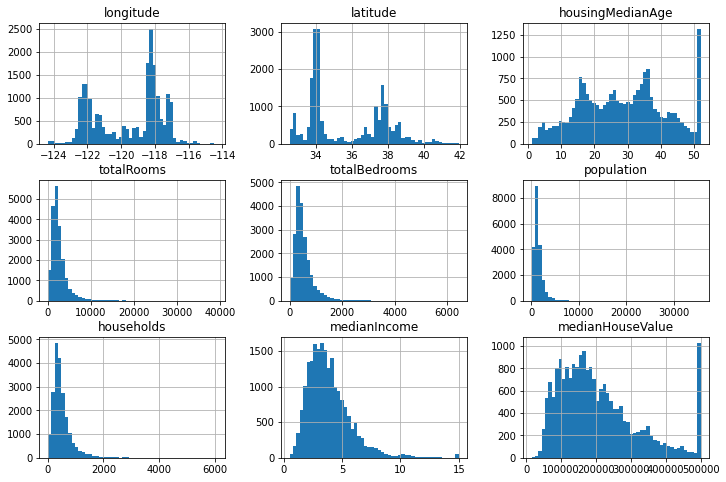

In [9]:
df.hist(bins=50, figsize=(12, 8))
plt.show()

In [10]:
import random
ex1, ex2, ex3 = random.sample(range(len(df)), 3)

print("Dataframe total rows: ", len(df))
df_info = pd.DataFrame(data = df.dtypes)
not_missing_values_total = df.notnull().sum()
not_missing_values_percent = round(not_missing_values_total/len(df)*100,2).astype(str)+" %"

pd.concat([df_info[0].rename("Data Type"),\
           df.T[ex1].rename("Example 1"),\
           df.T[ex2].rename("Example 2"),\
           df.T[ex3].rename("Example 3"),\
           not_missing_values_total.rename("Total Not Missing"), \
           not_missing_values_percent.rename("% of not missing values")], axis=1)

Dataframe total rows:  20640


,Data Type,Example 1,Example 2,Example 3,Total Not Missing,% of not missing values
longitude,float64,-117.8800,-117.9300,-121.4200,20640,100.0 %
latitude,float64,33.7100,33.6200,38.6400,20640,100.0 %
housingMedianAge,float64,30.0000,34.0000,42.0000,20640,100.0 %
totalRooms,float64,1739.0000,2125.0000,1720.0000,20640,100.0 %
totalBedrooms,float64,359.0000,498.0000,382.0000,20640,100.0 %
population,float64,1914.0000,1052.0000,1069.0000,20640,100.0 %
households,float64,369.0000,468.0000,362.0000,20640,100.0 %
medianIncome,float64,3.5551,5.6315,1.8611,20640,100.0 %
medianHouseValue,float64,185200.0000,484600.0000,60500.0000,20640,100.0 %


In [11]:
labels = ['D-', 'D', 'D+', 'C-', "C", 'C+', 'B', 'A']
df['medianIncome_tag'] = pd.qcut(df['medianIncome'], q = 8, labels = labels)

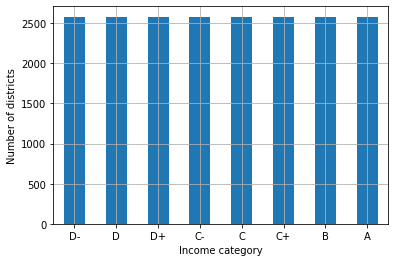

In [12]:
df["medianIncome_tag"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

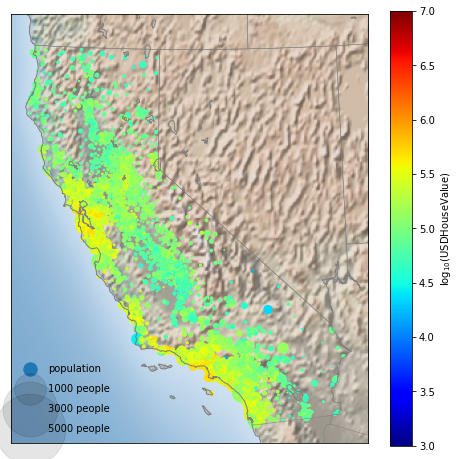

In [24]:
# 1. Draw the map background
fig = plt.figure(figsize=(8, 8))
m = Basemap(projection='lcc', resolution='h', 
            lat_0=37.5, lon_0=-119,
            width=1E6, height=1.2E6)
m.shadedrelief()
m.drawcoastlines(color='gray')
m.drawcountries(color='gray')
m.drawstates(color='gray')

# 2. scatter city data, with color reflecting population
# and size reflecting area
m.scatter(df["longitude"], df["latitude"], latlon=True,
          c=np.log10(df["medianHouseValue"]), s=df["population"]/100,  label="population",
          cmap='jet')

# 3. create colorbar and legend
plt.colorbar(label=r'$\log_{10}({\rm USD House Value })$')
plt.clim(3, 7)

# make legend with dummy points
for a in [1000, 3000, 5000]:
    plt.scatter([], [], c='k', alpha=0.1, s=a,
                label=str(a) + ' people')
plt.legend(scatterpoints=1, frameon=False,
           labelspacing=1, loc='lower left')
plt.show()

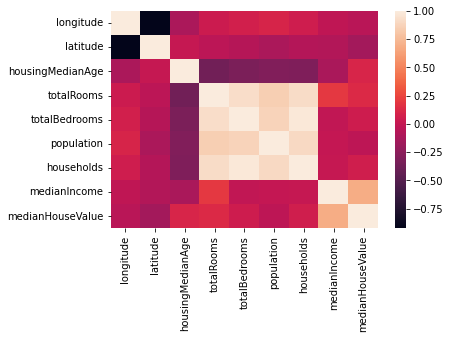

In [14]:
corr = df.corr()
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)
plt.show()

In [15]:
corr["medianHouseValue"].sort_values(ascending=False)

medianHouseValue    1.000000
medianIncome        0.688075
totalRooms          0.134153
housingMedianAge    0.105623
households          0.065843
totalBedrooms       0.050594
population         -0.024650
longitude          -0.045967
latitude           -0.144160
Name: medianHouseValue, dtype: float64

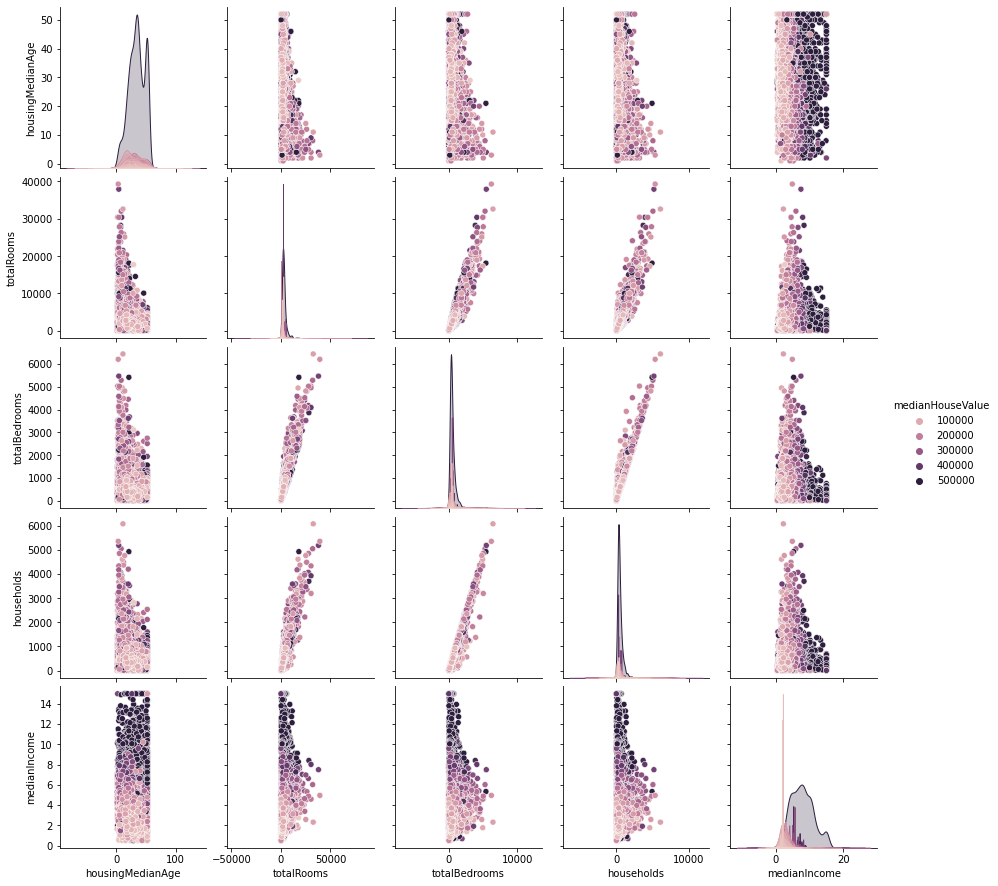

In [16]:
sns.pairplot(df[corr["medianHouseValue"][corr["medianHouseValue"] > 0].index.to_list()], hue="medianHouseValue")

# Generate new features

In [17]:
df["rooms_per_house"] = df["totalRooms"] / df["households"]
df["bedrooms_ratio"] = df["totalBedrooms"] / df["totalRooms"]
df["people_per_house"] = df["population"] / df["households"]

In [18]:
df.head(3)

,longitude,latitude,housingMedianAge,totalRooms,totalBedrooms,population,households,medianIncome,medianHouseValue,medianIncome_tag,rooms_per_house,bedrooms_ratio,people_per_house
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,A,6.984127,0.146591,2.555556
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,A,6.238137,0.155797,2.109842
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,A,8.288136,0.129516,2.802260


In [19]:
from sklearn.preprocessing import OrdinalEncoder

df_cat = df[["medianIncome_tag"]]
ordinal_encoder = OrdinalEncoder()
housing_cat_encoded = ordinal_encoder.fit_transform(df_cat)
df['medianIncome_tag'] = housing_cat_encoded

In [20]:
from sklearn.model_selection import train_test_split

X =  df.drop(labels = "medianHouseValue", axis = 1)
y = df['medianHouseValue']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.33, shuffle=True, stratify=df["medianIncome_tag"])

# TESTING SEVERAL MODELS AAND FINE TUNING

In [21]:
import xgboost as xgb
import optuna
from sklearn import metrics
from sklearn.metrics import mean_squared_error
from optuna.samplers import TPESampler
from xgboost import XGBRegressor
from optuna.integration import XGBoostPruningCallback
from sklearn.model_selection import RepeatedKFold
from optuna import create_study

def objective(
    trial,
    X,
    y,
    random_state=22,
    n_splits=3,
    n_repeats=2,
    n_jobs=1,
    early_stopping_rounds=50,
):
    # XGBoost parameters
    params = {
        "verbosity": 0,  # 0 (silent) - 3 (debug)
        "objective": "reg:squarederror",
        "n_estimators": 10000,
        "max_depth": trial.suggest_int("max_depth", 4, 12),
        "learning_rate": trial.suggest_loguniform("learning_rate", 0.005, 0.05),
        "colsample_bytree": trial.suggest_loguniform("colsample_bytree", 0.2, 0.6),
        "subsample": trial.suggest_loguniform("subsample", 0.4, 0.8),
        "alpha": trial.suggest_loguniform("alpha", 0.01, 10.0),
        "lambda": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "gamma": trial.suggest_loguniform("lambda", 1e-8, 10.0),
        "min_child_weight": trial.suggest_loguniform("min_child_weight", 10, 1000),
        "seed": random_state,
        "n_jobs": n_jobs,
    }

    model = XGBRegressor(**params)
    pruning_callback = XGBoostPruningCallback(trial, "validation_0-rmse")
    rkf = RepeatedKFold(
        n_splits=n_splits, n_repeats=n_repeats, random_state=random_state
    )
    X_values = X.values
    y_values = y.values
    y_pred = np.zeros_like(y_values)
    for train_index, test_index in rkf.split(X_values):
        X_A, X_B = X_values[train_index, :], X_values[test_index, :]
        y_A, y_B = y_values[train_index], y_values[test_index]
        model.fit(
            X_A,
            y_A,
            eval_set=[(X_B, y_B)],
            eval_metric="rmse",
            verbose=0,
            callbacks=[pruning_callback],
            early_stopping_rounds=early_stopping_rounds,
        )
        y_pred[test_index] += model.predict(X_B)
    y_pred /= n_repeats
    return np.sqrt(mean_squared_error(y_train, y_pred))

In [22]:
sampler = TPESampler(seed=124, multivariate=True)
study = create_study(direction="minimize", sampler=sampler)
study.optimize(
    lambda trial: objective(
        trial,
        X_train,
        y_train,
        random_state=124,
        n_splits=10,
        n_repeats=1,
        n_jobs=8,
        early_stopping_rounds=100,
    ),
    n_trials=2,
    n_jobs=1,
)

# display params
hp = study.best_params
for key, value in hp.items():
    print(f"{key:>20s} : {value}")
print(f"{'best objective value':>20s} : {study.best_value}")

Streaming output truncated to the last 5000 lines.
  step
/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7501 is already reported.
  step
/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7502 is already reported.
  step
/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7503 is already reported.
  step
/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7504 is already reported.
  step
/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `step` 7505 is already reported.
  step
/usr/local/lib/python3.7/dist-packages/optuna/trial/_trial.py:592: UserWarning: The reported value is ignored because this `ste

           max_depth : 4
       learning_rate : 0.027825404679231593
    colsample_bytree : 0.375053263116791
           subsample : 0.5495463565688764
               alpha : 0.14259940359422604
              lambda : 2.9235044300356874e-06
    min_child_weight : 216.73288837140979
best objective value : 48806.99834978039


# Solution

In [23]:
hp["verbosity"] = 0
hp["objective"] = "reg:squarederror"
hp["n_estimators"] = 10000
hp["seed"] = 124
hp["n_jobs"] = 8
model = XGBRegressor(**hp)
rkf = RepeatedKFold(n_splits=10, n_repeats=1, random_state=124)
X_values = X_train.values
y_values = y_train.values
y_pred = np.zeros_like(y_test.values)
for train_index, test_index in rkf.split(X_values):
    X_A, X_B = X_values[train_index, :], X_values[test_index, :]
    y_A, y_B = y_values[train_index], y_values[test_index]
    model.fit(
        X_A,
        y_A,
        eval_set=[(X_B, y_B)],
        eval_metric="rmse",
        early_stopping_rounds=100,
        verbose=0,
    )
    y_pred += model.predict(X_test.values)
y_pred /= 1 * 10

In [31]:
rmse = mean_squared_error(y_pred, y_test, squared=False)
rmse

49240.338926915865

In [27]:
df["medianHouseValue"].max()

500001.0